In [1]:
import jax
import jax.numpy as jnp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from jax import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from mnist import plot_error, plot_spikes, plot_traces, run, run_example
from spikegd.theta import ThetaNeuron
from spikegd.utils.plotting import (
    cm2inch,
    panel_label,
)

In [2]:
plt.style.use("spikegd.utils.plotstyle")

# Run experiments

In [3]:
config_theta = {
    "seed": 0,
    # Neuron
    "tau": 6 / jnp.pi,
    "I0": 5 / 4,
    "eps": 1e-6,
    # Network
    "Nin": 784,
    "Nin_virtual": 1,  # #Virtual input neurons = #Pixel value bins - 1
    "Nhidden": 100,
    "Nlayer": 3,  # Number of layers
    "Nout": 10,
    "w_scale": 0.5,  # Scaling factor of initial weights
    # Trial
    "T": 2.0,
    "K": 200,  # Maximal number of simulated ordinary spikes
    "dt": 0.001,  # Step size used to compute state traces
    # Training
    "gamma": 1e-2,
    "Nbatch": 1000,
    "lr": 4e-3,
    "tau_lr": 1e2,
    "beta1": 0.9,
    "beta2": 0.999,
    "p_flip": 0.02,
    "Nepochs": 100,
    "Ntrain": 1000, # Number of training samples
}


def run_theta(config: dict) -> dict:
    """
    Wrapper to train a network of Theta neurons with the given configuration.

    See docstring of `run` and article for more information.
    """
    tau, I0, eps = config["tau"], config["I0"], config["eps"]
    neuron = ThetaNeuron(tau, I0, eps)
    metrics = run(neuron, config, progress_bar="notebook")
    return metrics

In [4]:
seed = 0
samples = 1  # Number of network realizations, decrease to save simulation time
key = random.PRNGKey(seed)
seeds = random.randint(key, (samples,), 0, jnp.uint32(2**32 - 1), dtype=jnp.uint32)
metrics_list = []
for seed in seeds:
    config_theta["seed"] = seed
    metrics = run_theta(config_theta)
    metrics_list.append(metrics)
metrics_example = metrics_list[0]
metrics = jax.tree.map(lambda *args: jnp.stack(args), *metrics_list)

Full train_set shape: torch.Size([60000, 784])
Using reduced train_set size of 1000


  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
def summarize_metrics(metrics: dict, epoch: int) -> None:
    """
    Print a summary of the metrics at the given epoch.
    """
    summary_metrics = {k: v for k, v in metrics.items() if k not in ["p_init", "p_end"]}
    summary_metrics = jax.tree.map(
        lambda x: jnp.array([jnp.mean(x[:, epoch]), jnp.std(x[:, epoch])]),
        summary_metrics,
    )
    for key, value in summary_metrics.items():
        print(f"{key:<25} {value[0]:.3f} ± {value[1]:.3f}")


print("**Results before training**")
summarize_metrics(metrics, 0)
print()
print("**Results after training**")
summarize_metrics(metrics, -1)

**Results before training**
acc                       0.096 ± 0.000
acc_ord                   0.098 ± 0.000
activity                  0.000 ± 0.000
activity_first            0.000 ± 0.000
loss                      2.339 ± 0.000
loss_ord                  2.320 ± 0.000
silent_neurons            1.000 ± 0.000
silent_neurons_first      1.000 ± 0.000

**Results after training**
acc                       0.855 ± 0.000
acc_ord                   0.570 ± 0.000
activity                  0.525 ± 0.000
activity_first            0.508 ± 0.000
loss                      0.653 ± 0.000
loss_ord                  2.246 ± 0.000
silent_neurons            0.010 ± 0.000
silent_neurons_first      0.010 ± 0.000


In [6]:

def run_example_theta(p: list, config: dict) -> dict:
    """
    Wrapper to run network on one example input.

    See docstring of `run_example` and article for more information.
    """
    tau, I0, eps = config["tau"], config["I0"], config["eps"]
    neuron = ThetaNeuron(tau, I0, eps)
    metrics = run_example(p, neuron, config)
    return metrics


example_init = run_example_theta(metrics_example["p_init"], config_theta)
example_end = run_example_theta(metrics_example["p_end"], config_theta)

Full train_set shape: torch.Size([60000, 784])
Using reduced train_set size of 1000
Full train_set shape: torch.Size([60000, 784])
Using reduced train_set size of 1000


# Plot results

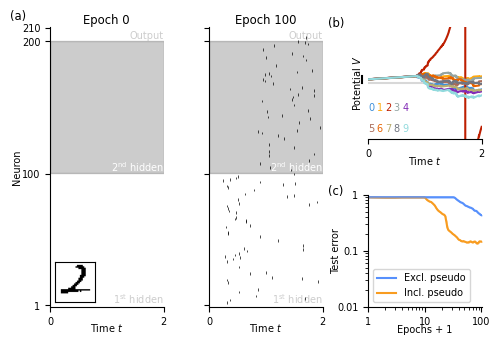

In [7]:
### Figure
fig = plt.figure(figsize=cm2inch(1.5 * 8.6, 1.5 * 6.0))
gs = gridspec.GridSpec(
    2,
    3,
    figure=fig,
    hspace=0.5,
    wspace=0.4,
    top=0.94,
    bottom=0.15,
    left=0.12,
    right=0.97,
)

#### Spike plot before learning
ax = fig.add_subplot(gs[:, 0])
plot_spikes(ax, example_init, config_theta)
ax.set_title("Epoch 0", pad=-1)
axins = inset_axes(ax, width=0.4, height=0.4, loc="lower left")
axins.imshow(example_init["input"].reshape(28, 28), cmap="gray")
axins.set_xticks([])
axins.set_yticks([])
axins.spines["top"].set_visible(True)
axins.spines["right"].set_visible(True)
panel_label(fig, ax, "(a)", x=-0.4, y=0.07)

#### Spike plot after learning
ax = fig.add_subplot(gs[:, 1])
plot_spikes(ax, example_end, config_theta)
ax.set_title(f"Epoch {config_theta['Nepochs']}", pad=-1)
ax.tick_params(labelleft=False)
ax.set_ylabel("")

### Trace output
ax = fig.add_subplot(gs[0, 2])
plot_traces(ax, example_end, config_theta)
panel_label(fig, ax, "(b)", x=-0.4, y=0.0)

### Accuracy plot
ax = fig.add_subplot(gs[1, 2])
plot_error(ax, metrics, config_theta)
panel_label(fig, ax, "(c)", x=-0.4, y=0.0)

plt.show()